In [1]:
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from pathlib import Path


basename = "enwiki-2016"
cat_file = Path("/data/graphs") / basename / "page2cat.tsv"
cat_list = []
ps = PorterStemmer()
for pos, line in enumerate(cat_file.open(encoding="utf-8")):
    temp = line.rstrip()
    words = word_tokenize(temp)
    final = [ps.stem(i) for i in words if i not in stopwords.words('english')]
    print(temp)
    print(final)
    if pos > 2:
        break

Anarchism	Political ideologies	Social theories	Political culture	Anti-capitalism	Far-left politics	Anarchism
['anarch', 'polit', 'ideolog', 'social', 'theori', 'polit', 'cultur', 'anti-capit', 'far-left', 'polit', 'anarch']
Değnek	Villages by country	Regions of Turkey	Populated places in Turkey by province
['değnek', 'villag', 'countri', 'region', 'turkey', 'popul', 'place', 'turkey', 'provinc']
Queensland Conservatorium Griffith University	Universities by country	Entertainment in Australia	Australian capital cities
['queensland', 'conservatorium', 'griffith', 'univers', 'univers', 'countri', 'entertain', 'australia', 'australian', 'capit', 'citi']
Octagon Chapel, Liverpool	Churches	Buildings and structures in England by city
['octagon', 'chapel', ',', 'liverpool', 'church', 'build', 'structur', 'england', 'citi']


In [3]:
%load_ext line_profiler

In [11]:
from collections import defaultdict


def build_cat_dict(cat_file):
    categories = defaultdict(list)
    for pos, line in enumerate(cat_file.open(encoding="utf-8")):
        temp = line.rstrip().split("\t", 1)
        try:
            key, raw_cat = temp[0], temp[1]
        except IndexError:
            continue
        categories[key] = preprocess_categs(raw_cat)
        if pos > 100:
            break
    return categories


def preprocess_categs(raw_categs):
    words = word_tokenize(raw_categs)
    doc = []
    for i in words:
        if i not in stopwords.words('english'):
            doc.append(ps.stem(i))
    return doc

In [12]:
%lprun -f build_cat_dict build_cat_dict(cat_file)

In [13]:
%lprun -f preprocess_categs build_cat_dict(cat_file)

In [14]:
def preprocess_categs(raw_categs):
    words = word_tokenize(raw_categs)
    return [ps.stem(w) for w in words]

In [15]:
%lprun -f preprocess_categs build_cat_dict(cat_file)

In [16]:
def build_cat_dict(cat_file):
    categories = defaultdict(list)
    stopw = set(stopwords.words('english'))
    for pos, line in enumerate(cat_file.open(encoding="utf-8")):
        temp = line.rstrip().split("\t", 1)
        try:
            key, raw_cat = temp[0], temp[1]
        except IndexError:
            continue
        categories[key] = preprocess_categs(raw_cat, stopw)
        if pos > 100:
            break
    return categories


def preprocess_categs(raw_categs, stopwords):
    words = word_tokenize(raw_categs)
    return [ps.stem(w) for w in words if w not in stopwords]

In [17]:
%lprun -f preprocess_categs build_cat_dict(cat_file)

In [20]:
from tqdm import tqdm
from collections import OrderedDict


def build_cat_dict(cat_file):
    categories = defaultdict(list)
    stopw = set(stopwords.words('english'))
    num_lines = sum(1 for _ in cat_file.open(encoding="utf-8"))
    for pos, line in enumerate(tqdm(cat_file.open(encoding="utf-8"), total=num_lines)):
        temp = line.rstrip().split("\t", 1)
        try:
            key, raw_cat = temp[0], temp[1]
        except IndexError:
            continue
        categories[key] = preprocess_categs(raw_cat, stopw)
    return categories

In [ ]:
categs = build_cat_dict(cat_file)

 18%|█▊        | 792668/4289768 [06:31<28:31, 2042.79it/s]

In [25]:
len(categs)

3192605

In [27]:
categs['Anarchism']

['polit',
 'ideolog',
 'social',
 'theori',
 'polit',
 'cultur',
 'anti-capit',
 'far-left',
 'polit',
 'anarch']

# TF-IDF

In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [34]:
docs = [' '.join(i) for i in categs.values()]
len(docs)

3192605

In [37]:
for pos, value in enumerate(docs):
    print(' '.join(value))
    if pos > 5:
        break

polit ideolog social theori polit cultur anti-capit far-left polit anarch
villag countri region turkey popul place turkey provinc
univers countri entertain australia australian capit citi
church build structur england citi
peopl statu peopl ethnic peopl ethnic occup indian peopl film director
scottish societi alumni univers colleg europ poetri nation languag scottish peopl occup
plant


In [44]:
sklearn_tfidf = TfidfVectorizer(norm='l2', min_df=0, use_idf=True, smooth_idf=False, sublinear_tf=True)
sklearn_representation = sklearn_tfidf.fit_transform(docs)
type(sklearn_representation)

In [47]:
sklearn_representation.shape

(3192605, 2461)

In [48]:
from sklearn.metrics.pairwise import cosine_similarity

x1 = sklearn_representation[0]
x2 = sklearn_representation[1]
cosine_similarity(x1, x2)

array([[0.]])

Learning it right:

In [87]:
key_list = []
docs_list = []
for key, value in categs.items():
    key_list.append(key)
    docs_list.append(' '.join(value))

In [88]:
doc_repr = sklearn_tfidf.fit_transform(docs_list)

# Plots

In [50]:
import sys

p = Path('.').resolve()
sys.path.append(str(p.parent))
from utils.data_utils import load_data

In [51]:
x, y = load_data(Path("/data/models/enwiki-2016"))

Labels not defined
Labels not defined
Labels not defined
Labels not defined
Labels not defined
Labels not defined
Labels not defined
Labels not defined
Labels not defined
Labels not defined
Labels not defined
Labels not defined
Labels not defined
Labels not defined
Labels not defined
Labels not defined
Labels not defined
Labels not defined
Labels not defined
Labels not defined


In [184]:
import numpy as np
import scipy
from scipy.spatial.distance import pdist


def get_id(basename, idx, ent_list):
    """
    Idx is currently a list.
    """
    ids_file = Path('/data/graphs/') / basename / (basename + '.urls')
    if not ids_file.exists():
        ids_file = Path('/data/graphs/') / basename / (basename + '.ids')
    assert ids_file.exists(), "File not found!"
    f = ids_file.as_posix()
    for node in idx:
        line = ent_list[node]
        yield linecache.getline(f, line + 1).rstrip()



def cosineSim_vs_distance(x, categories, entities, key_list, doc_list, n=100, dense_out=True):
    """
    """
    subset = np.random.choice(len(x), n, replace=False)
    ids = [i for i in get_id("enwiki-2016", subset, entities)]
    # polishing
    print("Removing nodes not contained in the categories dictionary..")
    indices = []
    for pos, value in enumerate(ids):
        if value in categories:
            if len(categories[value]) > 0: # this should always be true
                indices.append(pos)
    # keep only relevant ids and associated embeddings
    ids = [ids[i] for i in indices]
    subset = [subset[i] for i in indices]
    print("Effective number of nodes: {}".format(len(ids)))
    # compute
    mat = []
    for i in ids:
        idx = key_list.index(i)
        mat.append(doc_list[idx])
    mat = scipy.sparse.vstack(mat)
    sim = cosine_similarity(mat, dense_output=dense_out)
    if dense_out:
        sim = sim[np.triu_indices_from(sim, k=1)]
    dist = pdist(x[subset], 'euclidean')
    return sim, dist, ids


# Test on 10 points

In [122]:
temp1, temp2, temp3 = cosineSim_vs_distance(x, categs, entities, key_list, doc_repr, n=10)

Removing nodes not contained in the categories dictionary..
Effective number of nodes: 7
7


In [140]:
temp1

<7x7 sparse matrix of type '<class 'numpy.float64'>'
	with 11 stored elements in Compressed Sparse Row format>

In [124]:
print(scipy.sparse.triu(temp1, k=1))

  (0, 6)	0.1757733968820497
  (2, 5)	0.13781724510952068


In [141]:
len(temp2)

21

In [125]:
temp3

['Mikel Ruffinelli',
 'Secretary of State of Texas',
 'Stronger (Carlene Carter album)',
 'Central Public Works Department, India',
 'Molecular probe',
 'Sundbyhagen',
 'Jason Kendall']

In [126]:
categs["Mikel Ruffinelli"]

['peopl', 'statu', 'health', 'unit', 'state', 'lo', 'angel', ',', 'california']

In [127]:
categs["Jason Kendall"]

['peopl',
 'statu',
 'minor',
 'leagu',
 'basebal',
 'player',
 'team',
 'sport',
 'unit',
 'state',
 'citi',
 'basebal',
 'player',
 'team',
 'major',
 'leagu',
 'basebal',
 'sport',
 'california']

In [128]:
categs["Stronger (Carlene Carter album)"]

['countri', 'album', 'american', 'artist']

In [129]:
categs["Sundbyhagen"]

['villag', 'countri']

# Test on 1000 points

In [151]:
cos_sim, dist, ids = cosineSim_vs_distance(x, categs, entities, key_list, doc_repr, n=1000)

Removing nodes not contained in the categories dictionary..
Effective number of nodes: 626
626


In [131]:
%lprun -f cosineSim_vs_distance cosineSim_vs_distance(x, categs, entities, key_list, doc_repr)

Removing nodes not contained in the categories dictionary..
Effective number of nodes: 64
64


In [157]:
cos_sim2 = cos_sim[np.triu_indices_from(cos_sim, k=1)]
len(cos_sim2)

195625

In [158]:
len(dist)

195625

In [161]:
import matplotlib.pyplot as plt

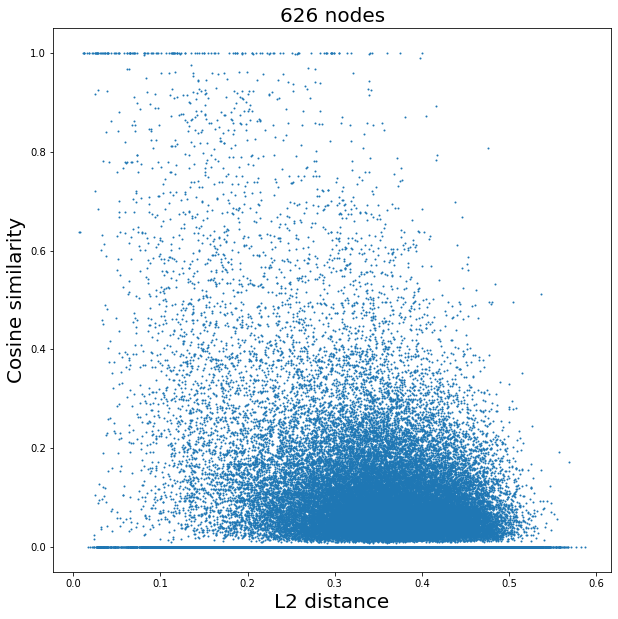

In [163]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_title("{} nodes".format(len(cos_sim)), fontsize=20)
plt.scatter(dist, cos_sim2, s=1)
ax.set_ylabel('Cosine similarity', fontsize=20)
ax.set_xlabel('L2 distance', fontsize=20)
plt.savefig('cs_vs_eudist.png', dpi=200)
plt.show()

another run..

In [185]:
cos_sim, dist, ids = cosineSim_vs_distance(x, categs, entities, key_list, doc_repr, n=1000)

Removing nodes not contained in the categories dictionary..
Effective number of nodes: 599


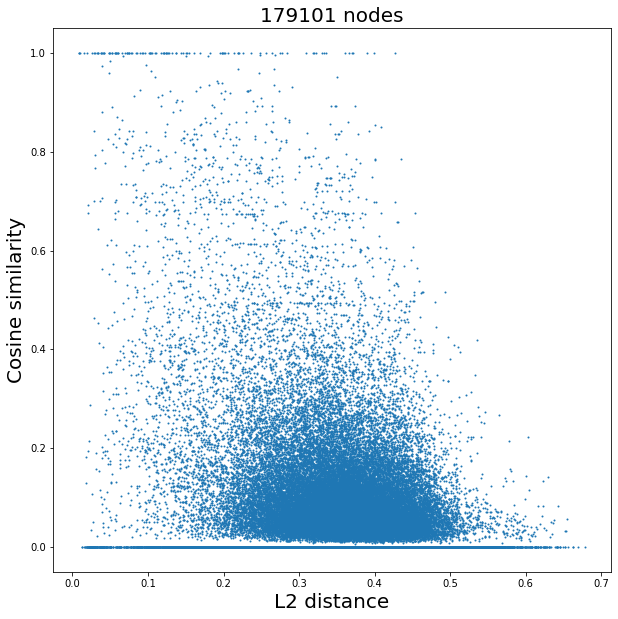

In [186]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_title("{} nodes".format(len(cos_sim)), fontsize=20)
plt.scatter(dist, cos_sim, s=1)
ax.set_ylabel('Cosine similarity', fontsize=20)
ax.set_xlabel('L2 distance', fontsize=20)
plt.savefig('cs_vs_eudist.png', dpi=200)
plt.show()

# False positives


In [176]:
from itertools import combinations


def false_positives(scores, dist, ids, categories, dist_value=0.05, scores_value=0):
    ind = np.where((dist <= dist_value) & (scores <= scores_value))[0]
    for pos, couple in enumerate(combinations(ids, 2)):
        if pos in ind:
            yield couple

def print_false_positives(value, categories):
    print("Node 1: {} - {}".format(value[0], categories[value[0]]))
    print("Node 2: {} - {}".format(value[1], categories[value[1]]))
    print()

In [179]:
fp = [i for i in false_positives(cos_sim2, dist, ids, categs)]

In [180]:
len(fp)

106

In [182]:
for i in fp:
    print_false_positives(i, categs)

Node 1: Fiery squirrel - ['vertebr', 'countri']
Node 2: Broad-toothed tailless bat - ['speci', 'describ', '20th', 'centuri']

Node 1: Walks Like Rihanna - ['song', 'songwrit', 'singer', 'nation', 'song', 'record', 'produc']
Node 2: Ultra.Dance 07 - ['compil', 'album']

Node 1: Enchō - ['histori', 'japan']
Node 2: Lino Isaia - ['content', 'life', 'peopl', 'statu', 'politician', 'nation']

Node 1: Enchō - ['histori', 'japan']
Node 2: Armand Bois - ['mayor', 'countri']

Node 1: Enchō - ['histori', 'japan']
Node 2: Balmshell - ['compani', 'canada', 'industri']

Node 1: Enchō - ['histori', 'japan']
Node 2: Ellen Clementine Howarth - ['modern', 'literatur', 'peopl', 'new', 'york', 'state', 'capit', 'unit', 'state']

Node 1: Enchō - ['histori', 'japan']
Node 2: Shepperd, Maryland - ['popul', 'place', 'maryland']

Node 1: Enchō - ['histori', 'japan']
Node 2: Walter Henderson (politician) - ['politician', 'nation', 'parti', 'citi', 'canada', 'provinc', 'territori']

Node 1: Enchō - ['histori', 

### Check if the common nodes in false positives have low L2 norm (so that the inner product with any other vector gives a 0 distance)

In [171]:
key_list.index('Lino Isaia')

1465878

In [172]:
entities.index(1465878)

2989824

In [173]:
x[2989824]

array([-0.01830687, -0.01152764, -0.00890484,  0.01452232,  0.00584718,
        0.01109101,  0.02040069,  0.00949135,  0.02062348,  0.0002321 ,
       -0.03569917,  0.01292909,  0.01074949,  0.01282492, -0.03393396,
        0.04035967,  0.01811427, -0.01403522,  0.01373766,  0.05030973,
        0.01948976, -0.00343536, -0.00226142,  0.00055545,  0.01413487,
       -0.00588594,  0.02560951,  0.00099909, -0.00491683,  0.00218368,
       -0.03537853, -0.0069618 ,  0.0070605 , -0.00123887, -0.00793211,
        0.04281955, -0.00768625,  0.01188336,  0.02212447, -0.00150223,
        0.0201883 , -0.02692894,  0.00628694,  0.01100709,  0.02027828,
       -0.00773982, -0.01793536,  0.01359584,  0.00536483, -0.00432487,
       -0.03678271,  0.01060591,  0.01268798, -0.01216578, -0.00437236,
        0.04655941, -0.0006091 , -0.0201156 ,  0.01798598, -0.01839439,
       -0.01734667,  0.00997702, -0.02706139, -0.0297146 ,  0.02129406,
        0.01993891,  0.00157414, -0.00293124,  0.02648482, -0.00

In [174]:
np.linalg.norm(x[2989824])

0.22325456